# just some experimentation :))

In [1]:
# silence warnings
import warnings
warnings.filterwarnings("ignore")

# allow helper import
import sys
sys.path.append('../../assets/scripts')

from cheff import CheffAEModel, CheffLDM
from cxrage import load_model, age_fn
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor

In [2]:
device = 'cpu'
sdm_path = '../../assets/models/cheff_diff_uncond.pt'
ae_path = '../../assets/models/cheff_autoencoder.pt'

cheff_ldm = CheffLDM(model_path=sdm_path, device=device)
cheff_ae = CheffAEModel(model_path=ae_path, device=device)

# load cxr-age
cxr_age = load_model(path='../../assets/')
cxr_age.model.to(device)

# load, encode sample images
sample_imgs = [Image.open(f'../../assets/cxrs/nih/ae_nih{i}.png') for i in range(1, 6)]
with torch.no_grad():
    lreps = [cheff_ae.encode(to_tensor(img).unsqueeze(0).to(device)) for img in sample_imgs]

In [7]:
samples = cheff_ldm.sample(
    batch_size = 5,
    sampling_steps=100,
    eta=1.0,
    decode=False
)

Data shape for DDIM sampling is (5, 3, 64, 64), eta 1.0
Running DDIM Sampling with 100 timesteps


DDIM Sampler: 100%|██████████| 100/100 [09:17<00:00,  5.58s/it]


In [17]:
n_lrep = 0.7 * lreps[0][0] + 0.3 * samples[0]
n_img = cheff_ae.decode(n_lrep.unsqueeze(0))

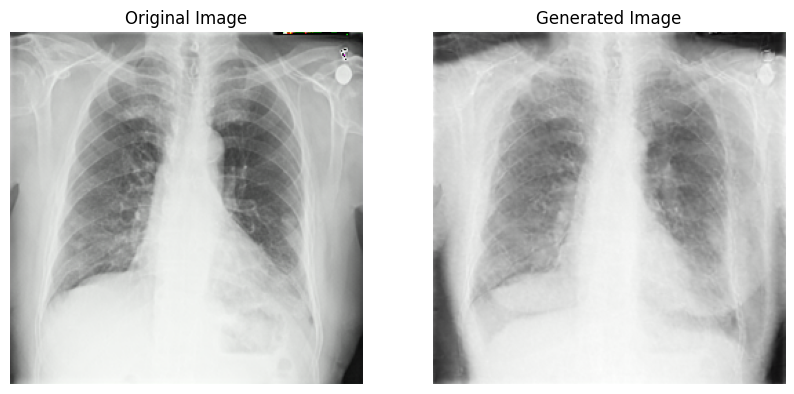

In [18]:
# randomly sample latent space reps near lreps[0]
lrep = lreps[0]
lrep += torch.randn_like(lrep) * 0.5

img = n_img.squeeze().cpu().detach().numpy()

# display sample_imgs[0], img
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(sample_imgs[0])
ax[0].axis('off')
ax[0].set_title('Original Image')
img = ((img - img.min()) / (img.max() - img.min())).transpose(1, 2, 0)
ax[1].imshow(img, cmap='gray')
ax[1].axis('off')
ax[1].set_title('Generated Image')
plt.show()